# Importing Packages

In [ ]:
import numpy as np 
import pandas as pd
import re

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


def accuracy(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    tn = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 0])
    return (tp + tn) / float(len(y_y_hat))

def f1(y, y_hat):
    precision_score = precision(y, y_hat)
    recall_score = recall(y, y_hat)
    numerator = precision_score * recall_score
    denominator = precision_score + recall_score
    return 2 * (numerator / denominator)

def precision(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fp = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 1])
    return tp / float(tp + fp)

def recall(y, y_hat):
    # Your code here
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fn = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 0])
    return tp / float(tp + fn)

def get_metrics(X_tr, y_tr, X_val, y_val, y_pred_tr, y_pred_val, model):
    print('Training Accuracy: ', accuracy(y_tr, y_pred_tr))
    print('Validation Accuracy: ', accuracy(y_val, y_pred_val))
    print('Training F1 Score: ', f1(y_tr, y_pred_tr))
    print('Validation F1 Score: ', f1(y_val, y_pred_val))
    print('Training AUC Score: {}'.format(roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])))
    print('Validation AUC Score: {}'.format(roc_auc_score(y_val, model.predict_proba(X_val)[:,1])))
    print('Training Recall Score: ', recall(y_tr, y_pred_tr))
    print('Validation Recall Score: ', recall(y_val, y_pred_val))
    print('Training Precision Score: ', precision(y_tr, y_pred_tr))
    print('Validation Precision Score: ', precision(y_val, y_pred_val))
    print('')
    print("Training Classification Report: ")
    print(classification_report(y_tr, y_pred_tr))
    print("")
    print("Validation Classification Report: ")
    print(classification_report(y_val, y_pred_val))
    
    cnf = confusion_matrix(y_val, y_pred_val)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

# Modeling Base Model without Feature Engineering

In [ ]:
tr = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_cleaned.csv")
val = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_cleaned.csv")

In [ ]:
tr.head()

In [ ]:
val.head()

In [ ]:
X_train = tr.drop(["default"], axis=1)
y_tr = tr["default"]
X_validate = val.drop(["default"], axis=1)
y_val = val["default"]


In [ ]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
# dum_feat = X_train[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# tr_dum.head()

In [ ]:
# dum_feat = X_validate[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# val_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# val_dum.head()

In [ ]:
# X_tr_dum = X_train.drop(['gender', 'education', 'marriage'], axis=1)
# X_tr_dum = X_tr_dum.join(tr_dum, how="left")
# X_val_dum = X_validate.drop(['gender', 'education', 'marriage'], axis=1)
# X_val_dum = X_val_dum.join(val_dum, how="left")

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_val = scaler.transform(X_validate)

In [ ]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_val = logreg.predict(X_val)
get_metrics(y_tr, y_val, y_pred_log_tr, y_pred_log_val, logreg)

In [ ]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

In [ ]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

In [ ]:
knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(y_tr, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

In [ ]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(y_tr, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

In [ ]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

In [ ]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_lda_tr, y_pred_lda_val, lda)

In [ ]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_gbc_tr, y_pred_gbc_val, gbc)

In [ ]:
xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)
get_metrics(y_tr, y_val, y_pred_xgb_tr, y_pred_xgb_val, xgb)

# Modeling with Feature Engineering

In [ ]:
tr2 = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_feature.csv")
val2 = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_feature.csv")

In [ ]:
tr2.head()

In [ ]:
val2.head()

In [ ]:
X_train2 = tr2.drop(["default"], axis=1)
y_tr = tr["default"]
X_validate2 = val2.drop(["default"], axis=1)
y_val = val["default"]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_tr2 = scaler.transform(X_train2)
X_val2 = scaler.transform(X_validate2)

In [ ]:
logreg2 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr2, y_tr)
y_pred_log_tr2 = logreg2.predict(X_tr2)
y_pred_log_val2 = logreg2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_log_tr2, y_pred_log_val2, logreg2)

In [ ]:
rfc2 = RandomForestClassifier().fit(X_tr2, y_tr)
y_pred_rfc_tr2 = rfc2.predict(X_tr2)
y_pred_rfc_val2 = rfc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_rfc_tr2, y_pred_rfc_val2, rfc2)

In [ ]:
dtc2 = DecisionTreeClassifier().fit(X_tr2, y_tr)
y_pred_dtc_tr2 = dtc2.predict(X_tr2)
y_pred_dtc_val2 = dtc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_dtc_tr2, y_pred_dtc_val2, dtc2)

In [ ]:
knn2 = KNeighborsClassifier().fit(X_tr2, y_tr)
y_pred_knn_tr2 = knn2.predict(X_tr2)
y_pred_knn_val2 = knn2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_knn_tr2, y_pred_knn_val2, knn2)

In [ ]:
gnb2 = GaussianNB().fit(X_tr2, y_tr)
y_pred_gnb_tr2 = gnb2.predict(X_tr2)
y_pred_gnb_val2 = gnb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gnb_tr2, y_pred_gnb_val2, gnb2)

In [ ]:
abc2 = AdaBoostClassifier().fit(X_tr2, y_tr)
y_pred_abc_tr2 = abc2.predict(X_tr2)
y_pred_abc_val2 = abc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_abc_tr2, y_pred_abc_val2, abc2)

In [ ]:
lda2 = LinearDiscriminantAnalysis().fit(X_tr2, y_tr)
y_pred_lda_tr2 = lda2.predict(X_tr2)
y_pred_lda_val2 = lda2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_lda_tr2, y_pred_lda_val2, lda2)

In [ ]:
gbc2 = GradientBoostingClassifier().fit(X_tr2, y_tr)
y_pred_gbc_tr2 = gbc2.predict(X_tr2)
y_pred_gbc_val2 = gbc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gbc_tr2, y_pred_gbc_val2, gbc2)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.metrics import geometric_mean_score



Bagging classifier performance:
Balanced accuracy: 0.65 - Geometric mean 0.58
Balanced Bagging classifier performance:
Balanced accuracy: 0.70 - Geometric mean 0.68

Training Accuracy:  0.9989047619047619
Validation Accuracy:  0.8115
Training F1 Score:  0.9975255513717051
Validation F1 Score:  0.45388701110574603
Training AUC Score: 0.9999937383097595
Validation AUC Score: 0.7472943343964304
Training Recall Score:  0.9957044673539519
Validation Recall Score:  0.357958872810358
Training Precision Score:  0.9993533089027807
Validation Precision Score:  0.6200527704485488

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    

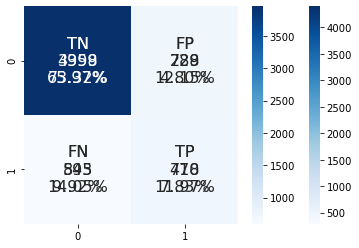

In [48]:
bagging = BaggingClassifier(n_estimators=50, random_state=42).fit(X_tr2, y_tr)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_tr2, y_tr)
y_pred_bc_tr = bagging.predict(X_tr2)
y_pred_bc_val = bagging.predict(X_val2)
y_pred_bbc_tr = balanced_bagging.predict(X_tr2)
y_pred_bbc_val = balanced_bagging.predict(X_val2)
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bc), geometric_mean_score(y_val, y_pred_bc)))
print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bbc), geometric_mean_score(y_val, y_pred_bbc)))
print("")
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_bc_tr, y_pred_bc_val, bagging)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_bbc_tr, y_pred_bbc_val, balanced_bagging)